# Sampling Borrowers from Historical User States

To avoid over-indexing on the exact debt distribution at the time of the simulation (i.e. the borrowers pulled from the subgraph), we resample debt positions from a Gaussian Kernel Density Estimator (KDE). A KDE provides a multi-variate, non-parametric probability density function (PDF). 

We randomly sample some pre-determined number of debt positions from this trained KDE, which provides us with a realistic borrower distribution for our simulations that more closely resembles the historical state of the crvUSD system compared to the exact distribution at the time we pull data from the subgraph.

This makes our risk model more hollistic: we consider the riskiness of the system with varying amounts of debt placed in random (but realistic) bands in each LLAMMA.

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pylab
from src.sim.scenario import Scenario
from copy import deepcopy
from src.plotting.sim import plot_borrowers_2d, plot_borrowers_3d, plot_reserves
from src.utils import get_historical_user_snapshots
from src.configs import LLAMMA_ALIASES

%load_ext autoreload
%autoreload 2

In [2]:
# Let's sample Q4 of 2023
start = int(datetime(2023, 10, 1).timestamp())
end = int(datetime(2024, 1, 1).timestamp())
market = LLAMMA_ALIASES["wsteth"]

In [3]:
df = get_historical_user_snapshots(market, start, end)
df.head()

,user,collateral,depositedCollateral,collateralUp,loss,lossPct,stablecoin,n,n1,n2,debt,health,timestamp,collateral_log,debt_log
id,,,,,,,,,,,,,,,
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xff05bd3180bc8e38f7aea981fe2af57f277bd9df,0xff05bd3180bc8e38f7aea981fe2af57f277bd9df,1.190680,1.199174,1.190680,0.008494,0.708339,0,4,69,72,1110.846628,0.033859,1696089851,0.174524,7.012878
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfde66fb9f020de05531534eae35c3785d75ad59c,0xfde66fb9f020de05531534eae35c3785d75ad59c,7.805002,7.805002,7.805002,0.000000,0.000000,0,4,71,74,7137.306973,0.033783,1696089851,2.054765,8.873091
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfd81b27d9796a1ba7d7171ea70010c9befb2a62a,0xfd81b27d9796a1ba7d7171ea70010c9befb2a62a,127.251573,127.251573,127.251573,0.000000,0.000000,0,10,74,83,108602.582700,0.043226,1696089851,4.846166,11.595450
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfccc0f1d9a3373aa031c7883ec8aca1e1dd35f3a,0xfccc0f1d9a3373aa031c7883ec8aca1e1dd35f3a,14.000000,14.152796,14.000000,0.152796,1.079616,0,4,64,67,13722.482649,0.034760,1696089851,2.639057,9.526791
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfcba7b991c337e78f5f36d5b37f229630d9cacd4,0xfcba7b991c337e78f5f36d5b37f229630d9cacd4,17.997159,20.049146,17.997159,2.051987,10.234784,0,4,10,13,29547.439346,0.062726,1696089851,2.890214,10.293752


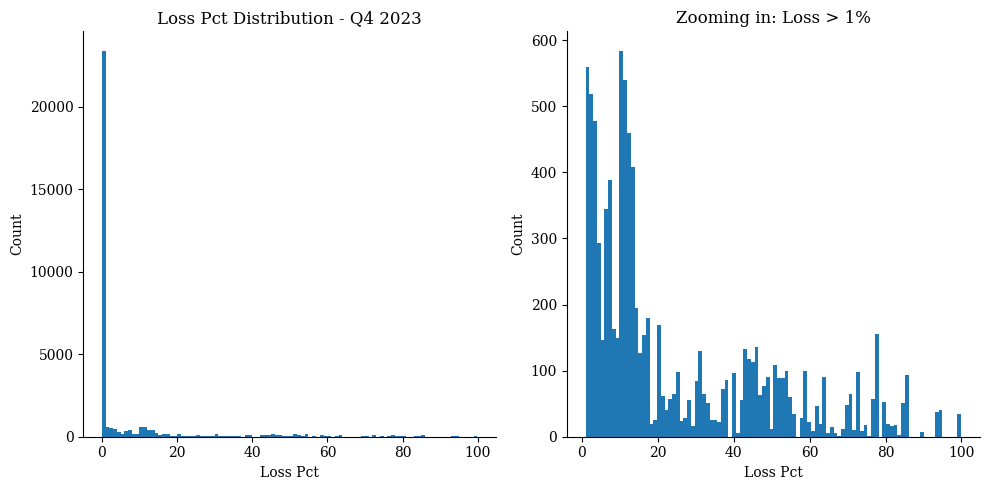

In [25]:
# Notice that most users experience little to no losses, but risky users in soft
# liquidation may experience meaningful losses

f, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(df["lossPct"], bins=100)
axs[0].set_title("Loss Pct Distribution - Q4 2023")
axs[0].set_xlabel("Loss Pct")
axs[0].set_ylabel("Count")

axs[1].hist(df[df["lossPct"] > 1]["lossPct"], bins=100)
axs[1].set_title("Zooming in: Loss > 1%")
axs[1].set_xlabel("Loss Pct")
axs[1].set_ylabel("Count")

f.tight_layout()
f.savefig("../figs/misc/loss_pct_dist.png")
plt.show()

### Normality

Notice that both debt and collateral are log-normally distributed, so we may apply a Gaussian KDE on the log of debt and collateral to sample new debt positions.

The number of bands per position (N) is clearly a bi-modal distribution around N=4 and N=10. This is expected: N=4 provides the most leverage, and N=10 is the default. This, however, means our Gaussian KDE will be less performant in sampling N than sampling debt or collateral.

Text(0.5, 1.0, 'N Distribution')

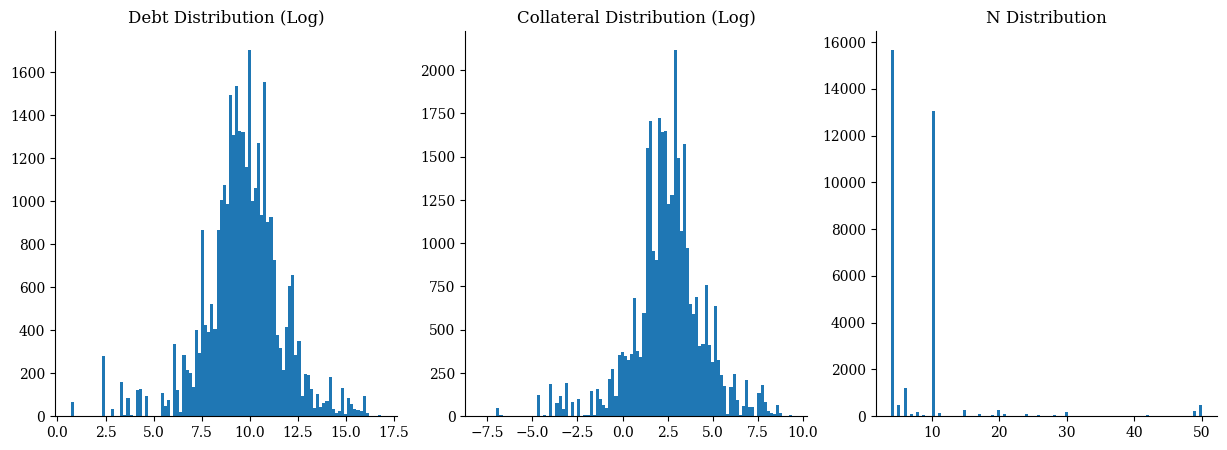

In [5]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
df["debt_log"].hist(bins=100, grid=False, ax=axs[0])
axs[0].set_title("Debt Distribution (Log)")
df["collateral_log"].hist(bins=100, grid=False, ax=axs[1])
axs[1].set_title("Collateral Distribution (Log)")
df["n"].hist(bins=100, grid=False, ax=axs[2])
axs[2].set_title("N Distribution")

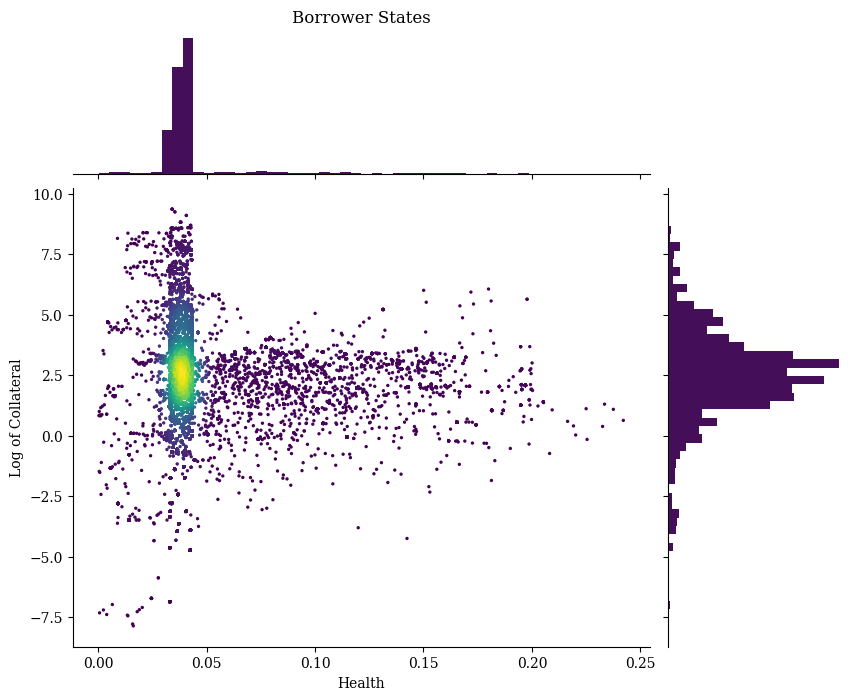

In [5]:
values = df[["health", "collateral_log"]].values.T
density = stats.gaussian_kde(values)(values)
fig = plot_borrowers_2d(*values, density)  # , xlim=(0.03, 0.05))

In [6]:
values = df[["health", "collateral_log", "n"]].values.T
density = stats.gaussian_kde(values)(values)
plot_borrowers_3d(*values, density)

# Randomly Sample Positions from KDE

Tried: KDE sampling health, collateral, and n, but it's not possible to quickly/accurately determine the corresponding debt required to arrive at that health because health is not a smooth/continuous/differentiable function.

New strategy: KDE sample debt, collateral, and n, and then check that health is reasonable. Plot the output and see if the generated positions are reasonable.

In [2]:
scenario_template = Scenario("severe growth", ["wsteth"])

[INFO][19:24:32][src.sim.scenario]-57657: Fetching wsteth market from subgraph
[INFO][19:24:35][src.sim.scenario]-57657: Market snapshot as 2024-01-17 18:00:11
[INFO][19:24:35][src.sim.scenario]-57657: Bands snapshot as 2024-01-16 19:52:35
[INFO][19:24:35][src.sim.scenario]-57657: Users snapshot as 2024-01-17 15:43:35
[INFO][19:24:43][src.sim.scenario]-57657: Using 245600 1Inch quotes from 2023-11-19 19:00:00 to 2023-12-19 19:00:00
[INFO][19:24:43][src.utils.poolgraph]-57657: Found 20 valid trading cycles of length 3.


### Plotting LLAMMA Reserves Without Resampling Debt Positions

1010
146538130.1285462


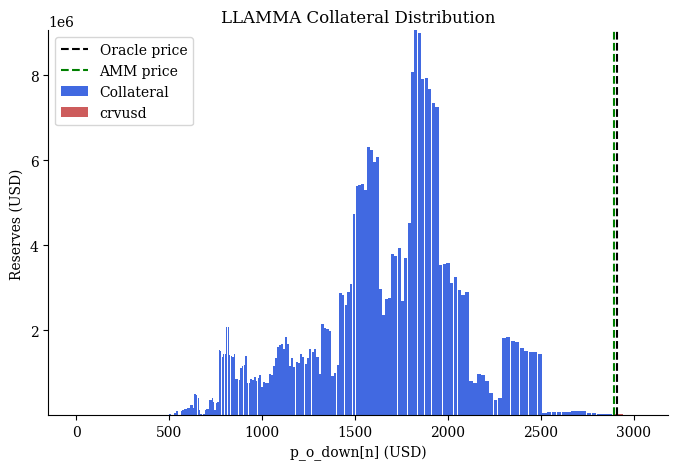

In [10]:
scenario_template_copy = deepcopy(scenario_template)
scenario_template_copy.prepare_for_run()
controller = scenario_template_copy.controllers[0]

print(controller.n_loans)
print((controller.total_debt()) / 1e18)

_ = plot_reserves(controller.AMM)

[CRITICAL][13:50:21][src.sim.scenario]-86784: READING KDE FROM FILE.
[INFO][13:50:21][src.sim.scenario]-86784: Equilibrated prices with 4 arbitrages with total profit 66766
[INFO][13:50:21][src.sim.scenario]-86784: Validating loaded positions in wstETH Controller.
[INFO][13:50:21][src.sim.scenario]-86784: 0.00% of debt (0 positions) was incorrectly loaded with <0 health (0 crvUSD)


350
55577245.65029412


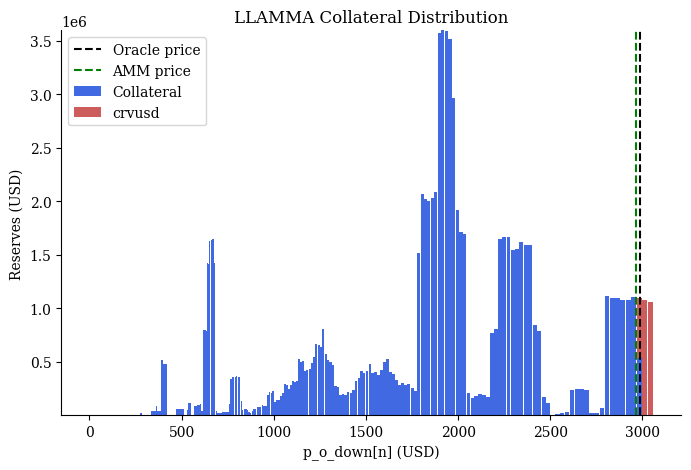

In [10]:
scenario = deepcopy(scenario_template)
controller = scenario.controllers[0]

scenario.prepare_for_run()

print(controller.n_loans)
print((controller.total_debt()) / 1e18)

_ = plot_reserves(controller.AMM)

### Total Debt, Collateral, and Loan Count over Time

The number of loans (and therefore, the total debt) in the re-sampled system is defined in the config for each scenario. The `num_loans` config is extracted from the Q4 average number of loans shown below. The sampled debt/collateral will be normally distributed around the mean.

In [2]:
pd.set_option("display.float_format", "{:,.0f}".format)


def plot_market_over_time(grouped, market):
    """
    Plot the total debt, collateral, and number of loans over time.
    """
    f, axs = plt.subplots(1, 3, figsize=(15, 5))

    grouped["debt"].plot(ax=axs[0])
    axs[0].set_title(f"Daily Debt in {market} Market")

    grouped["collateral"].plot(ax=axs[1])
    axs[1].set_title(f"Daily Collateral in {market} Market")

    grouped["num_loans"].plot(ax=axs[2])
    axs[2].set_title(f"Numberf of Loans in {market} Market")

    return f


def group(df):
    """
    Group user states df by datetime.
    """
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

    return df.groupby("datetime").agg(
        debt=("debt", "sum"),
        collateral=("collateral", "sum"),
        num_loans=("debt", "count"),
    )

In [7]:
percentiles = [0.01, 0.1, 0.5, 0.9, 0.99]

In [8]:
alias = "wsteth"
market = LLAMMA_ALIASES[alias]
df = get_historical_user_snapshots(market, start, end)
grouped = group(df)
_ = plot_market_over_time(grouped, alias)
grouped.describe(percentiles=percentiles)

,debt,collateral,num_loans
count,93,93,93
mean,"49,958,535","34,720",353
std,"14,331,227","8,389",34
min,"28,991,486","22,573",298
1%,"29,170,395","22,630",301
10%,"31,625,933","23,374",311
50%,"48,950,025","34,872",349
90%,"68,427,412","45,401",401
99%,"73,272,824","46,943",412
max,"73,654,901","48,209",414


,debt,collateral,num_loans
count,93,93,93
mean,"15,188,193","11,523",173
std,"6,563,214","3,677",66
min,"5,757,250","5,520",88
1%,"5,762,297","5,523",89
10%,"6,177,768","6,128",90
50%,"16,787,661","12,938",178
90%,"22,612,315","15,453",259
99%,"23,516,176","15,895",266
max,"23,618,552","16,317",267


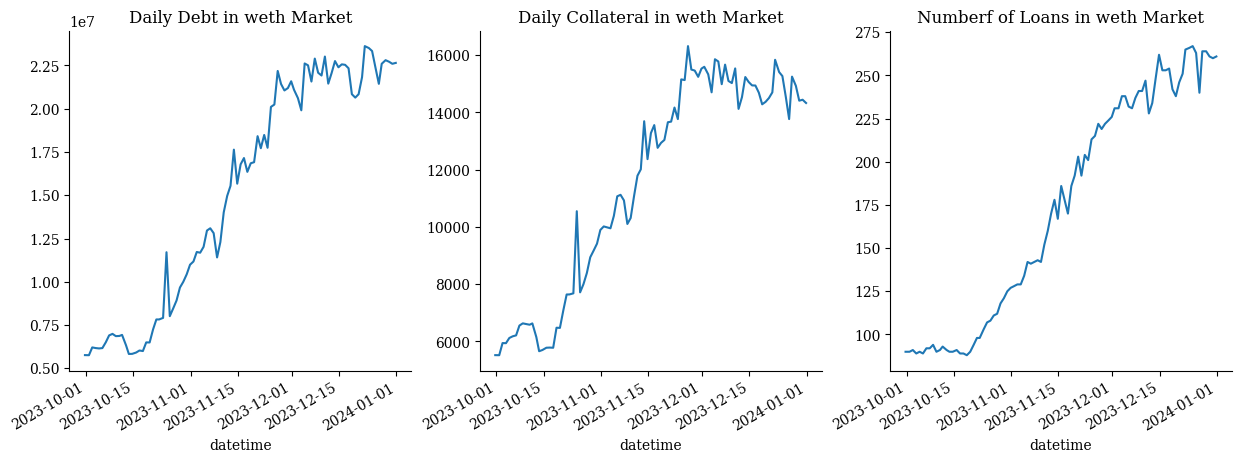

In [9]:
alias = "weth"
market = LLAMMA_ALIASES[alias]
df = get_historical_user_snapshots(market, start, end)
grouped = group(df)
_ = plot_market_over_time(grouped, alias)
grouped.describe(percentiles=percentiles)

,debt,collateral,num_loans
count,93,93,93
mean,"40,066,917","2,383",246
std,"6,627,952",581,50
min,"26,098,432","1,458",165
1%,"29,219,727","1,473",167
10%,"31,748,723","1,567",172
50%,"40,939,172","2,472",253
90%,"48,480,524","3,214",310
99%,"50,871,920","3,354",320
max,"50,968,746","3,362",321


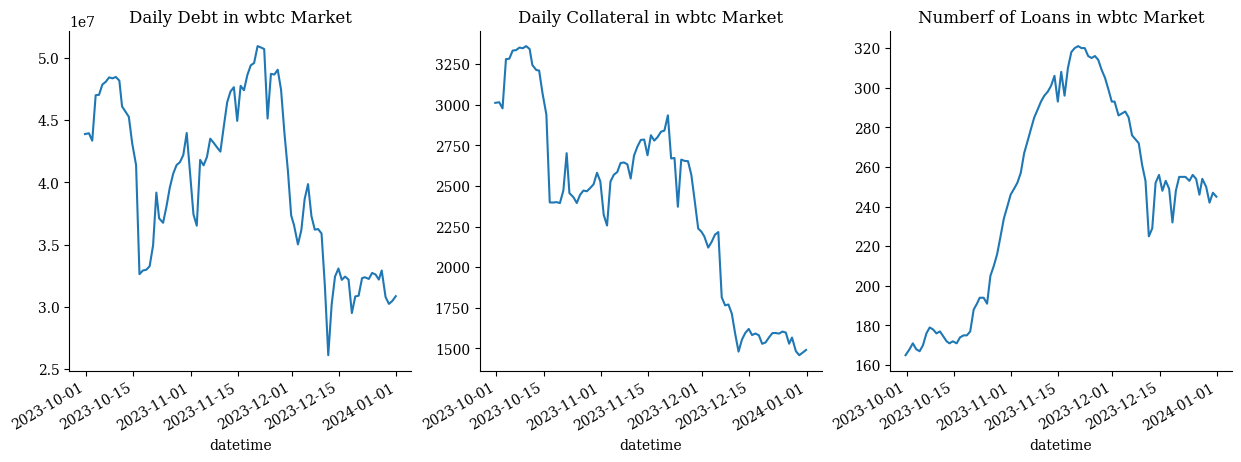

In [10]:
alias = "wbtc"
market = LLAMMA_ALIASES[alias]
df = get_historical_user_snapshots(market, start, end)
grouped = group(df)
_ = plot_market_over_time(grouped, alias)
grouped.describe(percentiles=percentiles)

,debt,collateral,num_loans
count,93,93,93
mean,"10,306,501","8,854",67
std,"1,805,888","1,427",8
min,"8,380,008","6,722",57
1%,"8,397,442","6,725",57
10%,"8,724,351","6,740",58
50%,"9,460,224","9,137",64
90%,"13,199,576","10,665",79
99%,"13,639,799","10,923",81
max,"13,643,564","10,926",81


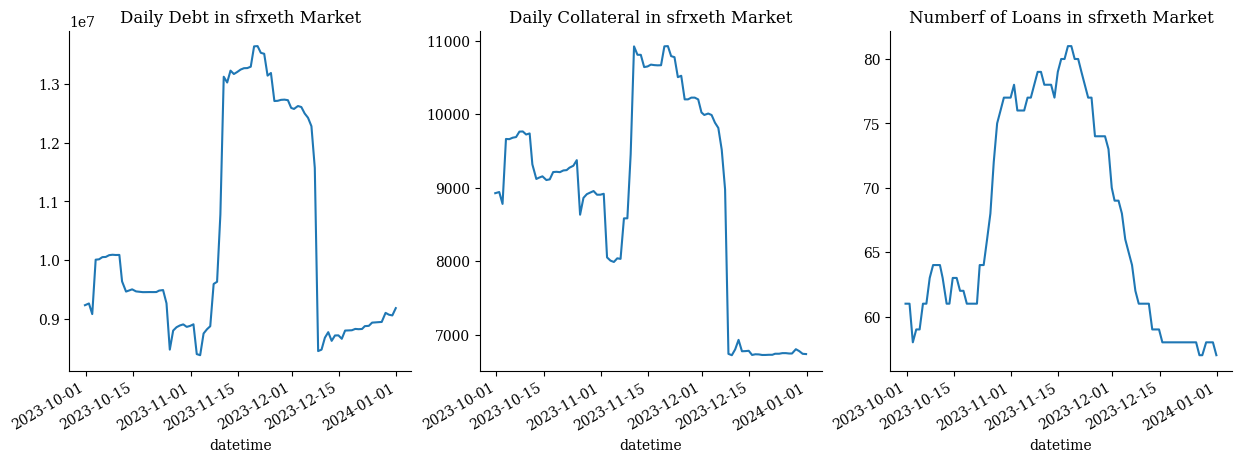

In [11]:
alias = "sfrxeth"
market = LLAMMA_ALIASES[alias]
df = get_historical_user_snapshots(market, start, end)
grouped = group(df)
_ = plot_market_over_time(grouped, alias)
grouped.describe(percentiles=percentiles)